# Project Milestone 3

In [48]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from scipy.stats import chi2_contingency

# Text and language processing
import gzip
import unicodedata
import re
import csv
import io
import pycld2 as cld2
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Geospatial data analysis and visualization
import geopandas as gpd
from shapely.wkt import loads

# Country-related libraries
import pycountry as py
import pycountry_convert as pc

# Image processing
from PIL import Image

# Machine learning and clustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Other miscellaneous imports
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import warnings



In [2]:
# Importations of our low-level methods 
from implementations import *

---
## Importing datasets


In [3]:
#Defining path for each dataset
current_dir = os.getcwd()
parent_folder_path = os.path.abspath(os.path.join(current_dir, ".."))
data_path = os.path.join(parent_folder_path, "data")

path_ba = data_path + '/BeerAdvocate'
path_rb = data_path + '/RateBeer'
path_mbd = data_path + '/matched_beer_data'

In [4]:
# Convert Beeradvocate reviews and ratings to csv 
txt_to_csv(path_ba,"reviews")
txt_to_csv(path_ba,"ratings")

reviews.csv is already present in the folder
ratings.csv is already present in the folder


In [5]:
# Convert RateBeer reviews and ratings to csv
txt_to_csv(path_rb,"reviews")
txt_to_csv(path_rb,"ratings")

reviews.csv is already present in the folder
ratings.csv is already present in the folder


In [4]:
#Import only the dataset we use
#BeerAdvocate
beers_ba = pd.read_csv(f"{path_ba}/{'beers.csv'}")
users_ba = pd.read_csv(f"{path_ba}/{'users.csv'}")
breweries_ba = pd.read_csv(f"{path_ba}/{'breweries.csv'}")
ratings_ba = pd.read_csv(f"{path_ba}/ratings.csv")
reviews_ba = pd.read_csv(f"{path_ba}/reviews.csv")

#RateBeer
beers_rb = pd.read_csv(f"{path_rb}/{'beers.csv'}")
users_rb = pd.read_csv(f"{path_rb}/{'users.csv'}")
breweries_rb = pd.read_csv(f"{path_rb}/{'breweries.csv'}")  
ratings_rb = pd.read_csv(f"{path_rb}/ratings.csv") #Ratings and Reviews are similar for RB, so we only use one of them

#Merged Beer Data
users_mbd = pd.read_csv(f"{path_mbd}/{'users.csv'}", header = 1) 

In [5]:
# Deep copies of all dataframes 
beers_ba_c = beers_ba.copy(deep=True)
users_ba_c = users_ba.copy(deep=True)
breweries_ba_c = breweries_ba.copy(deep=True)
ratings_ba_c = ratings_ba.copy(deep=True)
reviews_ba_c = reviews_ba.copy(deep=True)

beers_rb_c = beers_rb.copy(deep=True)
users_rb_c = users_rb.copy(deep=True)
breweries_rb_c = breweries_rb.copy(deep=True)
ratings_rb_c = ratings_rb.copy(deep=True)

users_mbd_c = users_mbd.copy(deep=True)

# 1. Introduction

Here we do all the code for graphs and observations necessary for the introduction

## Beers and ratings

### Number of beers for 15 largest styles BA & RB

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_1613/3200077325.py:24: UserWarning:

The figure layout has changed to tight



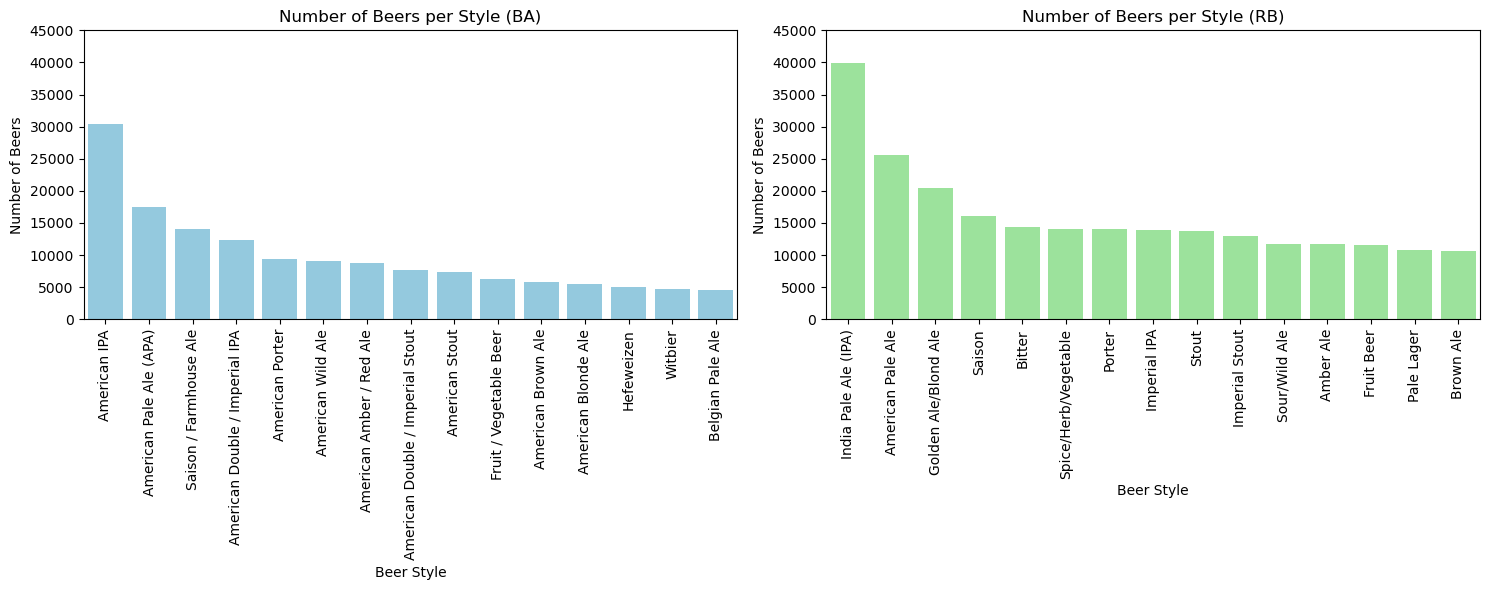

In [13]:
# Number of styles of beers 
nbr_style_ba = beers_ba_c['style'].value_counts().nlargest(15)
nbr_style_rb = beers_rb_c['style'].value_counts().nlargest(15)
plt.figure(figsize=(15, 6))

# Number of styles of beers for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x=nbr_style_ba.index, y=nbr_style_ba.values, color='skyblue')
plt.title('Number of Beers per Style (BA)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

# Number of styles of beers for RateBeer
plt.subplot(1, 2, 2)
sns.barplot(x=nbr_style_rb.index, y=nbr_style_rb.values, color='lightgreen')
plt.title('Number of Beers per Style (RB)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

plt.show()

### Number of ratings for the 15 bigger styles BA & RB

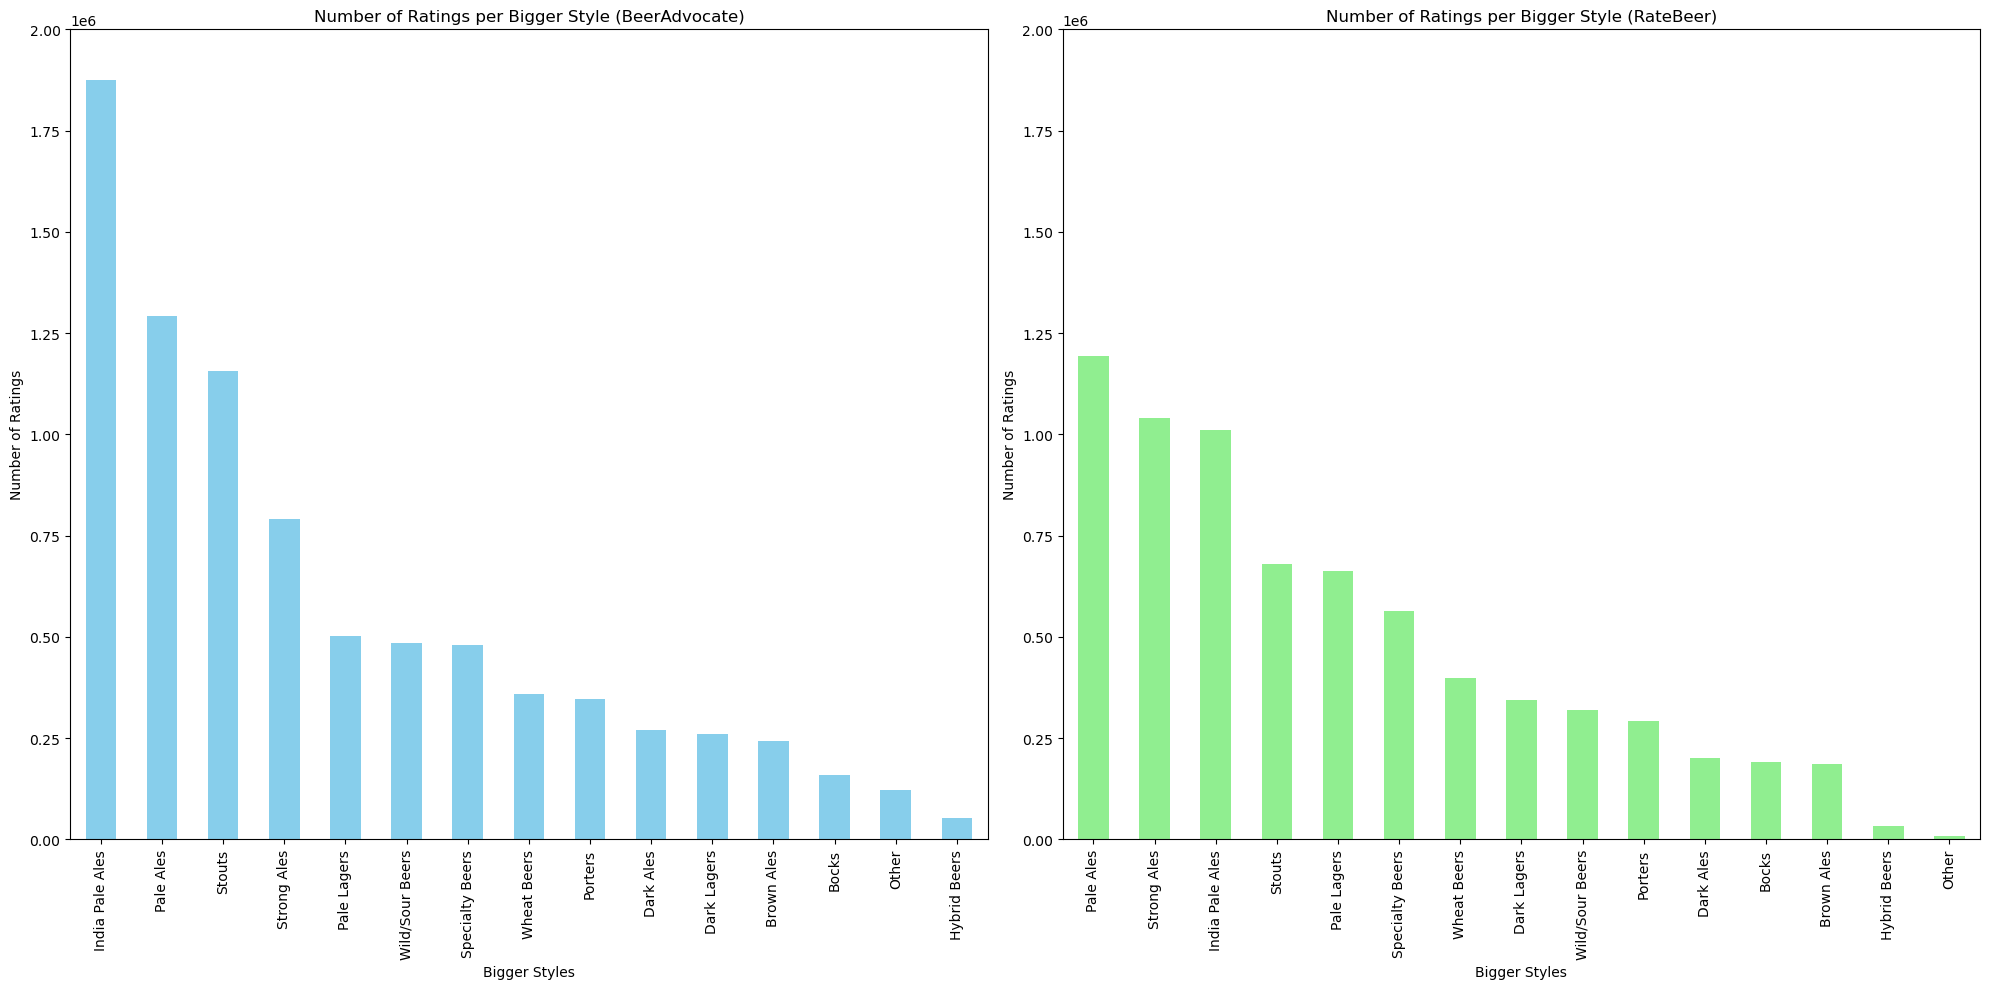

In [14]:
# Categorize each style with the Bigger styles of beer of each website 
beers_ba_c['bigger_style'] = beers_ba_c['style'].apply(categorize_style)
beers_rb_c['bigger_style'] = beers_rb_c['style'].apply(categorize_style)

ratings_per_bigger_style_ba = beers_ba_c.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)
ratings_per_bigger_style_rb = beers_rb_c.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 10))

# Plot for BeerAdvocate
plt.subplot(1,2,1)
ax1 = ratings_per_bigger_style_ba.plot(kind='bar', color='skyblue')
plt.title('Number of Ratings per Bigger Style (BeerAdvocate)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.ylim(0,2000000)
plt.xticks(rotation=90)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = ratings_per_bigger_style_rb.plot(kind='bar', color='lightgreen')
plt.title('Number of Ratings per Bigger Style (RateBeer)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.ylim(0,2000000)
plt.tight_layout()

plt.show()

# 2. Sentiment Analysis in Reviews

## Wordclouds

In [37]:
reviews_ba_w = reviews_ba_c.dropna(axis=0, subset='text')
reviews_ba_w = reviews_ba_w[['beer_id','user_id','style','rating','text']]
reviews_ba_w['bigger_style'] = reviews_ba_w['style'].apply(categorize_style)
reviews_ba_w = reviews_ba_w.drop(columns=['style'])

#Sort good and bad reviews based on the grade
good_reviews_ba_w =  reviews_ba_w[(reviews_ba_w['rating'] > 4)]
bad_reviews_ba_w =  reviews_ba_w[(reviews_ba_w['rating'] < 1.5)]

#Create a single string containing every reviews
good_reviews_str = ' '.join(good_reviews_ba_w['text'].astype(str))
bad_reviews_str = ' '.join(bad_reviews_ba_w['text'].astype(str))

#Define stopwords
stop_words = ["beer", "one", "taste", "t", "s", "pour", "pours", "poured", "quot"] + list(STOPWORDS)

In [36]:
#Create a color map for fancy wordclouds
cmap = plt.get_cmap('Wistia')
beer_cmap = truncate_colormap(cmap, 0.2, 1)

### Wordcloud for positive reviews

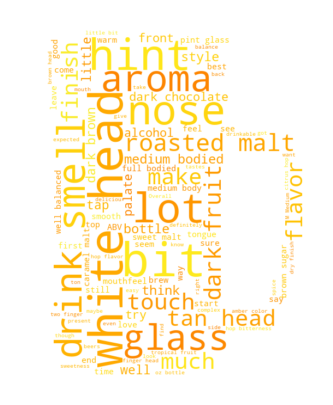

In [38]:
# Generate the word cloud
mask_beer = np.array(Image.open(f"{current_dir}/{'img/beer_mask.png'}"))
mask_beer=np.where(mask_beer == (0,0,0,0), 255, mask_beer)

wordcloud_good = WordCloud(width=400, 
                           height=800, 
                           background_color='white', 
                           mask=mask_beer,
                           max_words= 100,
                           colormap=beer_cmap,
                           stopwords=stop_words).generate(good_reviews_str)

# Generate colors so cloud has beer colors
#beer_colors = ImageColorGenerator(mask_beer)
#wordcloud_good.recolor(color_func = beer_colors)

wordcloud_good.to_file(os.path.join('plot', 'wordcloud_good.png'))


# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.show()

### Wordcloud for negative reviews

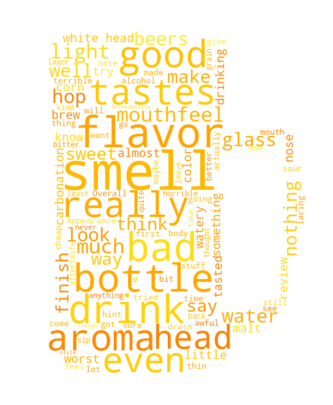

In [39]:
# Generate the word cloud
mask_beer = np.array(Image.open(f"{current_dir}/{'img/beer_mask.png'}"))
mask_beer=np.where(mask_beer == (0,0,0,0), 255, mask_beer)

wordcloud_bad = WordCloud(width=400, 
                           height=800, 
                           background_color='white', 
                           mask=mask_beer,
                           max_words= 100,
                           colormap=beer_cmap,
                           stopwords=stop_words).generate(bad_reviews_str)

wordcloud_bad.to_file(os.path.join('plot', 'wordcloud_bad.png'))


# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.show()

### Wordcloud for IPA reviews

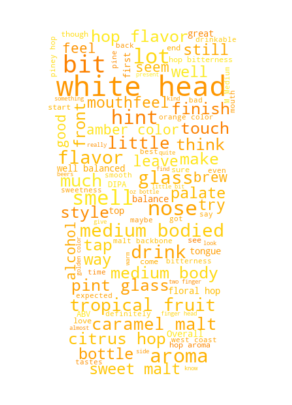

In [40]:
#Generate the string for IPA reviews
ipa_reviews = reviews_ba_w[reviews_ba_w['bigger_style'] == 'India Pale Ales']
ipa_reviews_str = ' '.join(ipa_reviews['text'].astype(str))

#Create the mask for the IPA
mask_ipa = np.array(Image.open(f"{current_dir}/{'img/ipa_mask.png'}"))
mask_ipa=np.where(mask_ipa == (0,0,0,0), 255, mask_ipa)

ipa_stop_words = stop_words + ["ipa"]


# Generate the word cloud
wordcloud_ipa = WordCloud(width=400, 
                          height=800, 
                          background_color='white',
                          mask=mask_ipa, 
                          max_words= 100,
                          colormap=beer_cmap,
                          stopwords= ipa_stop_words).generate(ipa_reviews_str)

wordcloud_ipa.to_file(os.path.join('plot', 'wordcloud_ipa.png'))

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ipa, interpolation='bilinear')
plt.axis('off')
plt.show()

### Wordcloud for Stout reviews

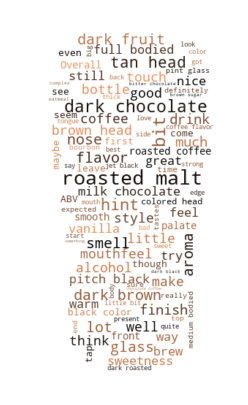

In [47]:
#Create the string for stouts
stout_reviews = reviews_ba_w[reviews_ba_w['bigger_style'] == 'Stouts']
stout_reviews_str = ' '.join(stout_reviews['text'].astype(str))

#Create the mask for the stouts
mask_stout = np.array(Image.open(f"{current_dir}/{'img/stout_mask.png'}"))
mask_stout=np.where(mask_stout == (0,0,0,0), 255, mask_stout)

stout_stop_words = stop_words + ["stout"]

stout_cmap = plt.get_cmap('copper')
stout_cmap = truncate_colormap(stout_cmap, 0, .75)

# Generate the word cloud
wordcloud_stout = WordCloud(width=400, 
                            height=800, 
                            background_color='white',
                            mask=mask_stout, 
                            max_words= 100,
                            colormap=stout_cmap,
                            stopwords= stout_stop_words).generate(stout_reviews_str)

wordcloud_stout.to_file(os.path.join('plot', 'wordcloud_stout.png'))

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_stout, interpolation='bilinear')
plt.axis('off')
plt.show()

## Top 10 words in each reviews

In [44]:
#Ignore a non-relevant warning:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

#Compute top 10 words for each review category
top_words_good = get_top_words(good_reviews_ba_w, 'text', stop_words)
top_words_good.columns = ['word_good', 'good_count']

top_words_bad = get_top_words(bad_reviews_ba_w, 'text', stop_words)
top_words_bad.columns = ['word_bad', 'bad_count']

top_words_ipa = get_top_words(ipa_reviews, 'text', ipa_stop_words)
top_words_ipa.columns = ['word_ipa', 'ipa_count']

top_words_stout = get_top_words(stout_reviews, 'text', stout_stop_words)
top_words_stout.columns = ['word_stout', 'stout_count']

In [45]:
warnings.resetwarnings()

In [46]:
#Display the top 10 words
#Convert DataFrames to dictionaries
dict_good = dict(zip(top_words_good['word_good'], top_words_good['good_count']))
dict_bad = dict(zip(top_words_bad['word_bad'], top_words_bad['bad_count']))
dict_ipa = dict(zip(top_words_ipa['word_ipa'], top_words_ipa['ipa_count']))
dict_stout = dict(zip(top_words_stout['word_stout'], top_words_stout['stout_count']))

#Create a new DataFrame
result_df = pd.DataFrame({'good_reviews_top_words': list(dict_good.keys()), 
                          'good_count': list(dict_good.values()),
                          'bad_reviews_top_words': list(dict_bad.keys()),
                          'bad_count': list(dict_bad.values()),
                          'ipa_reviews_top_words': list(dict_ipa.keys()), 
                          'ipa_count': list(dict_ipa.values()),
                          'stout_reviews_top_words': list(dict_stout.keys()), 
                          'stout_count': list(dict_stout.values()),
                          })

#Display the results
display(result_df)

,good_reviews_top_words,good_count,bad_reviews_top_words,bad_count,ipa_reviews_top_words,ipa_count,stout_reviews_top_words,stout_count
0,head,958340,head,6378,hops,474274,chocolate,430829
1,nice,773231,light,5339,head,414921,dark,367979
2,good,608726,smell,4373,hop,338873,coffee,360571
3,dark,585969,bottle,4143,nice,330469,head,303552
4,sweet,568938,bad,4055,citrus,321717,black,258506
5,malt,560709,good,3625,malt,311277,roasted,216729
6,light,559784,drink,3420,good,301976,nice,191504
7,hops,558642,flavor,3371,orange,245643,good,181297
8,well,524882,water,3165,white,222329,sweet,168930
9,carbonation,480083,even,3156,light,221703,brown,157774


# 3. Chronological and Geographical Analysis

### Preprocess

In [6]:
# Merge beers and brewery on brewery id
ba_beer_brewery = pd.merge(beers_ba_c, breweries_ba_c, left_on=['brewery_id'], right_on=['id'])
ba_beer_brewery = ba_beer_brewery.drop(columns=['avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

rb_beer_brewery= pd.merge(beers_rb_c, breweries_rb_c, left_on=['brewery_id'], right_on=['id'])
rb_beer_brewery = rb_beer_brewery.drop(columns=['avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

# Rename the countries that don't have the right format to be converted into ISO 3166 norm
ba_beer_brewery['location_grouped'] = ba_beer_brewery['location'].apply(rename_country)
rb_beer_brewery['location_grouped'] = rb_beer_brewery['location'].apply(rename_country)

# Add a column for the ISO 3166 norm
ba_beer_brewery['location_with_iso'] = ba_beer_brewery['location_grouped'].apply(add_iso_code)
rb_beer_brewery['location_with_iso'] = rb_beer_brewery['location_grouped'].apply(add_iso_code)

# Convert every country into its corresponding continent into a new column 'continent'
ba_beer_brewery['continent'] = ba_beer_brewery['location_grouped'].apply(country_to_continent)
rb_beer_brewery['continent'] = rb_beer_brewery['location_grouped'].apply(country_to_continent)

# Create a new column where all the states of the US are reunited 
ba_beer_brewery['countries'] = ba_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)
rb_beer_brewery['countries'] = rb_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

In [7]:
# For BeerAdvocate 
ratings_ba_f_drop = ratings_ba_c.drop(columns=['beer_name', 'brewery_id','brewery_name','style','abv','user_name', 
                                                'appearance', 'rating', 'aroma', 'palate', 'taste', 'overall', 'text', 'review'])

users_ba_f_drop = users_ba_c.drop(columns=['nbr_reviews', 'user_name', 'joined'])
users_ba_f_drop = users_ba_f_drop.rename(columns={'location': 'user_location'})

ratings_users_ba = pd.merge(ratings_ba_f_drop, users_ba_f_drop, on='user_id')

ba_beer_brewery_drop = ba_beer_brewery.drop(columns=['brewery_id', 'brewery_name', 'nbr_reviews',
                                                           'bros_score', 'abv', 'id', 'name', 'nbr_ratings'])

beer_user_ba = pd.merge(ratings_users_ba, ba_beer_brewery_drop, on='beer_id')

# For RateBeer 
ratings_rb_f_drop = ratings_rb_c.drop(columns=['beer_name', 'brewery_id','brewery_name','style','abv','user_name',
                                                'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text'])

users_rb_f_drop = users_rb_c.drop(columns=['user_name', 'joined'])
users_rb_f_drop = users_rb_f_drop.rename(columns={'location': 'user_location'})

ratings_users_rb = pd.merge(ratings_rb_f_drop, users_rb_f_drop, on='user_id')

rb_beer_brewery_drop = rb_beer_brewery.drop(columns=['brewery_id', 'brewery_name', 'nbr_ratings', 'style_score', 
                                                        'abv', 'id', 'name'])

beer_user_rb = pd.merge(ratings_users_rb, rb_beer_brewery_drop, on='beer_id')

In [8]:
beer_user_ba.dropna(subset=['user_location'], inplace=True)
beer_user_rb.dropna(subset=['user_location'], inplace=True)

In [9]:
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
beer_user_ba['user_location_grouped'] = beer_user_ba['user_location'].apply(rename_country)
beer_user_rb['user_location_grouped'] = beer_user_rb['user_location'].apply(rename_country)

# Add a column for the ISO 3166 norm
beer_user_ba['user_location_with_iso'] = beer_user_ba['user_location_grouped'].apply(add_iso_code3)
beer_user_rb['user_location_with_iso'] = beer_user_rb['user_location_grouped'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
beer_user_ba['user_continent'] = beer_user_ba['user_location_grouped'].apply(country_to_continent)
beer_user_rb['user_continent'] = beer_user_rb['user_location_grouped'].apply(country_to_continent)

In [10]:
# Convert the date to the right format 
beer_user_ba['date'] = convert_to_date(beer_user_ba['date'])
beer_user_rb['date'] = convert_to_date(beer_user_rb['date'])

# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
beer_user_ba['date'] = pd.to_datetime(beer_user_ba['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
beer_user_rb['date'] = pd.to_datetime(beer_user_rb['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

# Create the bigger styles of beer column 
beer_user_ba['bigger_style'] = beer_user_ba['style'].apply(categorize_style)
beer_user_rb['bigger_style'] = beer_user_rb['style'].apply(categorize_style)

# Beers that have a score (range 0-100) > to the 3rd quartile
ba_style_year_filtered = beer_user_ba[beer_user_ba['ba_score'] >= beer_user_ba['ba_score'].quantile(0.75)]
rb_style_year_filtered = beer_user_rb[beer_user_rb['overall_score'] >= beer_user_rb['overall_score'].quantile(0.75)]

# Beers that have an average grade (range 0-5) > to the 3rd quartile
ba_style_year_filtered = ba_style_year_filtered[ba_style_year_filtered['avg'] >= ba_style_year_filtered['avg'].quantile(0.75)]
rb_style_year_filtered = rb_style_year_filtered[rb_style_year_filtered['avg'] >= rb_style_year_filtered['avg'].quantile(0.75)]

In [11]:
# Aggregate data for BeearAdvocate 
grouped_style_ba = aggregate_data(ba_style_year_filtered, 'style', 'user_location')
grouped_Bstyle_ba = aggregate_data(ba_style_year_filtered, 'bigger_style', 'user_location')

# Aggregate data for RateBeer
grouped_style_rb = aggregate_data(rb_style_year_filtered, 'style', 'user_location')
grouped_Bstyle_rb = aggregate_data(rb_style_year_filtered, 'bigger_style', 'user_location')

In [12]:
# Compute the total number of ratings per year
total_ratings_per_year_ba = pd.DataFrame(ba_style_year_filtered.groupby('date').count()["beer_id"])
total_ratings_per_year_ba = total_ratings_per_year_ba.rename(columns={"beer_id": "total_nbr_ratings"})

total_ratings_per_year_rb = pd.DataFrame(rb_style_year_filtered.groupby('date').count()["beer_id"])
total_ratings_per_year_rb = total_ratings_per_year_rb.rename(columns={"beer_id": "total_nbr_ratings"})

### Normalized number of ratings for each bigger style of beer each year 

In [13]:
# Add missing styles to the RateBeer DataFrame 
new_row1 = {'beer_id': 0, 'beer_name': 'Hybrid', 'style': 'Hybrid', 'bigger_style': 'Hybrid',
            'nbr_ratings': 0, 'avg': 0, 'ratings_info': {'2000': {'nbr_ratings': 0, 'avg': 0, 'location': 'Hybrid'}}}

new_row2 = {'beer_id': 0, 'beer_name': 'Other', 'style': 'Other', 'bigger_style': 'Other',
            'nbr_ratings': 0, 'avg': 0, 'ratings_info': {'2000': {'nbr_ratings': 0, 'avg': 0, 'location': 'Other'}}}

new_row3 = {'beer_id': 0, 'beer_name': 'Pale Lager', 'style': 'Pale Lager', 'bigger_style': 'Pale Lagers',
            'nbr_ratings': 0, 'avg': 0, 'ratings_info': {'2000': {'nbr_ratings': 0, 'avg': 0, 'location': 'Pale Lagers'}}}
new_row_df = pd.DataFrame([new_row1, new_row2, new_row3])

grouped_Bstyle_rb = pd.concat([grouped_Bstyle_rb, new_row_df], ignore_index=True)

# Sort the DataFrame by 'bigger_style' by alphabetical order
grouped_Bstyle_rb = grouped_Bstyle_rb.sort_values(by='bigger_style')
grouped_Bstyle_ba = grouped_Bstyle_ba.sort_values(by='bigger_style')

#### For RateBeer

In [14]:
fig1 = plot_normalized_ratings_by_group(grouped_Bstyle_rb, 'bigger_style', 'Normalized Number of Ratings per Year for Each Bigger Style', total_ratings_per_year_rb)

fig1.update_layout(width=690,height=600,legend_title_text='Beer Style')

html_file_path = "plot/rb_normalized_ratings_690px_custom_palette.html"
pyo.plot(fig1, filename=html_file_path)

'plot/rb_normalized_ratings_690px_custom_palette.html'

#### For BeerAdvocate

In [15]:
fig2 = plot_normalized_ratings_by_group(grouped_Bstyle_ba, 'bigger_style', 'Normalized Number of Ratings per Year for Each Bigger Style', total_ratings_per_year_ba)

fig2.update_layout(width=690, height=600, legend_title_text='Beer Style')

html_file_path = "plot/ba_normalized_ratings_690px.html"
pyo.plot(fig2, filename=html_file_path)

'plot/ba_normalized_ratings_690px.html'

### Mean increase of the number of ratings across the years 

#### For BeerAdvocate

In [16]:
fig3 = plot_increase_ratings(grouped_Bstyle_ba)  

fig3.update_layout(width=690, height=600)

html_file_path = "plot/ba_increase_ratings_690px.html"
pyo.plot(fig3, filename=html_file_path)

Mean Increase for each style per year:
Mean Increase for India Pale Ales: 217.70%
Mean Increase for Pale Ales: 610.90%
Mean Increase for Stouts: 129.22%
Mean Increase for Strong Ales: 120.00%
Mean Increase for Wild/Sour Beers: 107.95%

------------------------------------------------------

Mean Increase for each style between first year and last year:
Mean Increase for India Pale Ales: 117460.00%
Mean Increase for Pale Ales: 39412.50%
Mean Increase for Stouts: 86726.67%
Mean Increase for Strong Ales: 10238.89%
Mean Increase for Wild/Sour Beers: 15417.65%


'plot/ba_increase_ratings_690px.html'

#### For RateBeer

In [17]:
fig4 = plot_increase_ratings(grouped_Bstyle_rb)  

fig4.update_layout(width=690, height=600)

html_file_path = "plot/rb_increase_ratings_690px.html"
pyo.plot(fig4, filename=html_file_path)

Mean Increase for each style per year:
Mean Increase for India Pale Ales: 280.78%
Mean Increase for Porters: 92.28%
Mean Increase for Stouts: 68.07%
Mean Increase for Strong Ales: 93.21%
Mean Increase for Wild/Sour Beers: 81.40%

------------------------------------------------------

Mean Increase for each style between first year and last year:
Mean Increase for India Pale Ales: 29088.24%
Mean Increase for Porters: 9794.44%
Mean Increase for Stouts: 60716.67%
Mean Increase for Strong Ales: 19144.44%
Mean Increase for Wild/Sour Beers: 18077.78%


'plot/rb_increase_ratings_690px.html'

### Number of IPA ratings in the world throughout the years 

#### For BeerAdvocate

In [18]:
countries_ba_ipa = ratings_per_country(grouped_Bstyle_ba, 'India Pale Ales', 'user_location_grouped', 'ratings_info', rename_country, add_iso_code3, country_to_continent)

fig5 = px.choropleth(
    countries_ba_ipa,
    locations="location_with_iso",
    color="log_nbr_ratings",
    hover_name="country",
    hover_data={"country": True, "location_with_iso": False, "nbr_ratings": True, "log_nbr_ratings": False},
    animation_frame="year",
    projection="natural earth",
    color_continuous_scale='YlOrBr',
    range_color=(countries_ba_ipa['log_nbr_ratings'].min(), countries_ba_ipa['log_nbr_ratings'].max())
)

fig5.update_layout(width=690, height=600, margin=dict(l=1, r=1, t=0, b=0))

fig5.update_coloraxes(colorbar=dict(
    title='Number of Ratings (Log)',  
    tickfont=dict(size=10),  
    thickness=15,
    title_side='right'))
fig5.show()

html_file_path = "plot/ba_IPA_worldmap_690px.html"
pyo.plot(fig5, filename=html_file_path)

'plot/ba_IPA_worldmap_690px.html'

#### For RateBeer

In [19]:
countries_rb_ipa = ratings_per_country(grouped_Bstyle_rb, 'India Pale Ales', 'user_location_grouped', 'ratings_info', rename_country, add_iso_code3, country_to_continent)

fig6 = px.choropleth(
    countries_rb_ipa,
    locations="location_with_iso",
    color="log_nbr_ratings",
    hover_name="country",
    hover_data={"country": True, "location_with_iso": False, "nbr_ratings": True, "log_nbr_ratings": False},
    animation_frame="year",
    projection="natural earth",
    color_continuous_scale='YlOrBr',
    range_color=(countries_rb_ipa['log_nbr_ratings'].min(), countries_rb_ipa['log_nbr_ratings'].max())
)

fig6.update_layout(width=690, height=600, margin=dict(l=1, r=1, t=0, b=0))

fig6.update_coloraxes(colorbar=dict(
    title='Number of Ratings (Log)',  
    tickfont=dict(size=10),  
    thickness=15,
    title_side='right'))
fig6.show()

html_file_path = "plot/rb_IPA_worldmap_690px.html"
pyo.plot(fig6, filename=html_file_path)

'plot/rb_IPA_worldmap_690px.html'

### IPA's number of ratings focused on the USA

Since most ratings in RateBeer are not from the US we will not visualize the evolution of the ratings across the states of the US fro RateBeer. We will only study the IPA's number of ratings across the US for BeerAdvocate. 

In [20]:
us_states = gpd.read_file('cb_2021_us_state_500k/cb_2021_us_state_500k.shp')

# Extract centroid, latitude and longitude from the data 
us_states['centroid'] = us_states['geometry'].centroid
us_states['latitude'] = us_states['centroid'].y
us_states['longitude'] = us_states['centroid'].x

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_1997/3839584597.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [21]:
grouped_beer_ba = aggregate_data(ba_style_year_filtered, 'beer_id', 'user_location')

locations_ba_ipa = ratings_per_locations(grouped_beer_ba, 'bigger_style', 'ratings_info', rename_country, add_iso_code3, 
                                         country_to_continent, 'India Pale Ales')

In [22]:
animated_fig = ratings_per_US_states(locations_ba_ipa, us_states, 'bigger_style', 'India Pale Ales', 'year', 'location', 'nbr_ratings')
animated_fig.show()

animated_fig.update_layout(width=690, height=600)

html_file_path = "plot/ba_IPA_USAmap_690px.html"
pyo.plot(animated_fig, filename=html_file_path)

'plot/ba_IPA_USAmap_690px.html'

# 4. Social Analysis

## Fanbase Analysis

### Preprocess

In [23]:
# Merge the users that appear in both site with the users of RateBeer
merged_df_rb = pd.merge(users_rb_c, users_mbd_c[['user_id.1']], how='left', left_on='user_id', right_on='user_id.1', indicator=True)

# Keep only the users that appear only in RateBeer
result_df = merged_df_rb[merged_df_rb['_merge'] == 'left_only']
result_df = result_df.drop(columns=['_merge', 'user_id.1'])

# Drop unwanted columns 
users_ba_f_drop = users_ba_c.drop(columns=['user_name', 'joined', 'nbr_reviews'])

# Concatenate unique users of BeerAdvocate and RateBeer 
all_users = pd.concat([result_df, users_ba_f_drop], ignore_index=True)

In [24]:
# Create a data containing ratings from BA and RB
ratings = pd.concat([ratings_ba_c, ratings_rb_c], ignore_index=True)

In [25]:
# Only keep the unique users of both sites, found in all_users 
users = ratings[ratings['user_id'].isin(all_users['user_id'])]

In [26]:
users = users[['style','user_id','rating']]
users['bigger_style'] = users['style'].apply(categorize_style)

# Only keep users that posted 5 ratings or more (so we don't have "fans" that gave 2 ratings)
user_ratings_counts = users['user_id'].value_counts()
valid_users = user_ratings_counts[user_ratings_counts >= 5].index
users = users[users['user_id'].isin(valid_users)]

### Creating Fanbase

In [27]:
# Start by defining the percentage of rating per beer style for each users
style_percentage = users.groupby(['user_id', 'bigger_style'])['rating'].count() / users.groupby('user_id')['rating'].count()

# Keep only user that have one of the percentages >.75 
fan_users = style_percentage[style_percentage >= 0.75].reset_index()
 
# Identify the preferred style
fan_users = fan_users.groupby('user_id')['bigger_style'].first().reset_index()

# Enrich with informations from the first dataset
fan_users = pd.merge(fan_users, users, on=['user_id', 'bigger_style'], how='left')

# Reduce to one row per user, by computing the mean grade given to preferred style
fan_users = fan_users.groupby(['user_id', 'bigger_style'])['rating'].mean().reset_index()

# Enrich with the location by merging with user df
user_loc = all_users[['user_id', 'location']]
fans = pd.merge(fan_users, user_loc, on = ['user_id'], how = 'left')

fans.columns = ['user_id', 'preferred_style', 'avg_rating','location']

In [28]:
# Now we extract statistics about the users
fan_per_style = fans['preferred_style'].value_counts()
print(f"Number of fans for each style of beer", fan_per_style)

print("\n------------------------------------------------------\n")

style_avg_rating_by_fan = fans.groupby('preferred_style')['avg_rating'].mean().reset_index()
style_avg_rating_by_fan['avg_rating'] = sorted(style_avg_rating_by_fan['avg_rating'],reverse= True)
print(f"Average grade of the fans for each style of beer", style_avg_rating_by_fan)

Number of fans for each style of beer preferred_style
India Pale Ales    3061
Pale Lagers         872
Stouts              341
Strong Ales         271
Pale Ales           202
Specialty Beers      83
Wild/Sour Beers      82
Wheat Beers          80
Dark Lagers          16
Porters              10
Bocks                 6
Brown Ales            3
Dark Ales             2
Other                 2
Name: count, dtype: int64

------------------------------------------------------

Average grade of the fans for each style of beer     preferred_style  avg_rating
0             Bocks    4.400000
1        Brown Ales    4.328332
2         Dark Ales    4.300592
3       Dark Lagers    4.275961
4   India Pale Ales    4.231830
5             Other    4.150241
6         Pale Ales    4.098333
7       Pale Lagers    4.078103
8           Porters    3.985153
9   Specialty Beers    3.875000
10           Stouts    3.577860
11      Strong Ales    3.544417
12      Wheat Beers    3.435656
13  Wild/Sour Beers    2.63959

### Fanbase for each beer style

In [29]:
plot_df = fan_per_style.reset_index()
plot_df.columns = ['Style', 'Number of Fans']

fig = px.bar(plot_df, x='Style', y='Number of Fans',
             labels={'Number of fans': 'Number of fans (log scale)', 'Style': 'Beer Style'},
             title='Number of Fans for Each Beer Style (BA and RB cumulated)',
             log_y=True,
             color_discrete_sequence=['orange']
             )
fig.update_yaxes(tickvals=[1, 10, 100, 1000, 10000],
                 ticktext=['1', '10', '100', '1k', '10k'])
                 
fig.update_layout(xaxis=dict(tickangle=-45, tickmode='array'))

fig.show()

### Number of fans per country 

In [30]:
nan_indices = fans['location'].isnull()
fans = fans[~nan_indices]
fans = fans.dropna()

fans_ipa = fans[fans['preferred_style'] == 'India Pale Ales'].reset_index()

# Rename the countries that don't have the right format to be converted into ISO 3166 norm
fans_ipa['country'] = fans_ipa['location'].apply(rename_country)

# Add a column for the ISO 3166 norm
fans_ipa['fan_location_with_iso'] = fans_ipa['country'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
fans_ipa['fan_continent'] = fans_ipa['country'].apply(country_to_continent)

In [31]:
user_per_country = fans_ipa.groupby(['country', 'fan_location_with_iso'])['user_id'].count().reset_index()
user_per_country = user_per_country.rename(columns={'user_id': 'nbr_users'})

avg_rating_per_country = fans_ipa.groupby(['country', 'fan_location_with_iso'])['avg_rating'].mean().reset_index()

# Merge the two DataFrames on the country and iso column
merged_data = pd.merge(user_per_country, avg_rating_per_country, on=['country', 'fan_location_with_iso'])

# Create a choropleth map
fig = px.choropleth(merged_data, 
                    locations="fan_location_with_iso",  # You can change this to 'country' if needed
                    color="nbr_users",
                    hover_name="country",
                    title="Number of Fans and Average Rating per Country",
                    projection="natural earth",
                    color_continuous_scale="YlOrBr",  # You can choose another color scale
                    labels={'nbr_users': 'Number of Fans', 'avg_rating': 'Average Rating'})

# Update the hover template to display average rating
fig.update_traces(hovertemplate='<b>%{customdata[0]}</b><br>Number of Fans: %{z}<br>Average Rating: %{customdata[1]:.2f}',
                  customdata=merged_data[['country', 'avg_rating']])

fig.update_geos(
    showcoastlines=True,
    coastlinecolor="Black",
    showland=True,
    landcolor="rgb(217, 217, 217)",
)
fig.update_coloraxes(colorbar=dict(
    title='Number of Fans',  
    tickfont=dict(size=10),  
    thickness=15,
    title_side='right'))

fig.update_layout(width=690, height=600)
fig.show()

html_file_path = "plot/fan_IPA_worldmap_690px.html"
pyo.plot(fig, filename=html_file_path)

'plot/fan_IPA_worldmap_690px.html'

## Microbreweries Analysis

### Occurence of microbrewery-related terms in reviews

In [57]:
# Creating dataframe for microbrewery analysis
reviews_ba_m = reviews_ba_c.dropna(axis=0, subset='text')
reviews_ba_m = reviews_ba_m[['style','rating','date', 'text']]
reviews_ba_m['bigger_style'] = reviews_ba_m['style'].apply(categorize_style)
reviews_ba_m = reviews_ba_m.drop(columns=['style'])

reviews_rb_m = ratings_rb_c.dropna(axis=0, subset='text')
reviews_rb_m = reviews_rb_m[['style','rating','date', 'text']]
reviews_rb_m['bigger_style'] = reviews_rb_m['style'].apply(categorize_style)
reviews_rb_m = reviews_rb_m.drop(columns=['style'])

# Convert the date to the right format 
reviews_ba_m['date'] = convert_to_date(reviews_ba_m['date'])
reviews_rb_m['date'] = convert_to_date(reviews_rb_m['date'])

# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
reviews_ba_m['date'] = pd.to_datetime(reviews_ba_m['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
reviews_rb_m['date'] = pd.to_datetime(reviews_rb_m['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

merged_reviews = pd.concat([reviews_ba_m,reviews_rb_m],ignore_index=True)
ipa_review = merged_reviews[merged_reviews['bigger_style']== 'India Pale Ales']
stout_review = merged_reviews[merged_reviews['bigger_style']== 'Stouts']
pa_review = merged_reviews[merged_reviews['bigger_style']== 'Pale Ales']
sa_review = merged_reviews[merged_reviews['bigger_style']== 'Strong Ales']


In [58]:
#Computing percentage of microbreweries-related terms from every reviews
key_words = ['microbrewery', 'microbreweries', 'craft', 'crafts', 'brewpub', 
             'local', 'micro', 'crafty', 'taproom', 'regional', 'homebrewery', 
             'homebrewing']

overall_percentage = review_keyword_percentage(df=merged_reviews, key_words=key_words)
overall_percentage = overall_percentage.sort_index()

ipa_percentage = review_keyword_percentage(df=ipa_review, key_words=key_words)
ipa_percentage = ipa_percentage.sort_index()

stout_percentage = review_keyword_percentage(df=stout_review, key_words=key_words)
stout_percentage = stout_percentage.sort_index()

pa_percentage = review_keyword_percentage(df=pa_review, key_words=key_words)
pa_percentage = pa_percentage.sort_index()

sa_percentage = review_keyword_percentage(df=sa_review, key_words=key_words)
sa_percentage = sa_percentage.sort_index()

In [59]:
# Create traces for each DataFrame
trace_overall = go.Scatter(x=overall_percentage.index, y=overall_percentage['percentage_with_keywords'],
                           mode='lines', name='Percentage of reviews <br>about microbreweries',
                           line=dict(color='sea green'))

trace_ipa = go.Scatter(x=ipa_percentage.index, y=ipa_percentage['percentage_with_keywords'],
                      mode='lines', name='Percentage of IPA reviews <br>about microbreweries',
                      line=dict(color='orange'))

trace_stout = go.Scatter(x=stout_percentage.index, y=stout_percentage['percentage_with_keywords'],
                      mode='lines', name='Percentage of Stouts reviews <br>about microbreweries',
                      line=dict(color='brown'))

trace_pa = go.Scatter(x=pa_percentage.index, y=pa_percentage['percentage_with_keywords'],
                      mode='lines', name='Percentage of Pale Ales reviews <br>about microbreweries',
                      line=dict(color='gold'))

trace_sa = go.Scatter(x=sa_percentage.index, y=sa_percentage['percentage_with_keywords'],
                      mode='lines', name='Percentage of Strong Ales reviews <br>about microbreweries',
                      line=dict(color='red'))


# Create the layout
layout = go.Layout(
    title='Percentage of reviews with keyword related to microbreweries',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Percentage')
    #legend=dict(x=0.88, y=0.3, traceorder='normal', orientation='h')
)

# Create the figure with both traces
fig = go.Figure(data=[trace_overall, trace_ipa, trace_stout, trace_pa, trace_sa], layout=layout)

# Export to HTML 
config = dict(
    toImageButtonOptions=dict(
        format='png',  
        filename='plot'
    )
)
fig.update_layout(width=690, height=500)

html_file_path = "plot/microbrewery_ipa_overall.html"
pyo.plot(fig, filename=html_file_path, config=config)

'plot/microbrewery_ipa_overall.html'

### Statistical analysis of microbreweries-related terms occurence

In [35]:
# Create contingency table
overall_with_keyw = overall_percentage['reviews_with_keywords'].values
overall_without_keyw = (overall_percentage['total_reviews'] - overall_percentage['reviews_with_keywords']).values
ipa_with_keyw = ipa_percentage['reviews_with_keywords'].values
ipa_without_keyw = (ipa_percentage['total_reviews'] - ipa_percentage['reviews_with_keywords']).values

contingency_tab = np.array([[overall_with_keyw.sum(), overall_without_keyw.sum()],
                     [ipa_with_keyw.sum(), ipa_without_keyw.sum()]])

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_tab)

# Print results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

# Interpret the results
if p < 0.05:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")

Chi-square statistic: 853.3470774423852
P-value: 1.361151041492536e-187
Reject the null hypothesis: There is a significant difference.


# 5. Clustering